In [20]:
# load the data from the csv file
# use pandas to read the csv file
# set the data to a variable called df2

import pandas as pd
import re
from google.colab import drive
drive.mount('/content/drive')
datafile = r"winemag-data-130k-v2.csv"
df2 = pd.read_csv(datafile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleansing

In [23]:
# This function extracts the vintage from the wine title. It returns the first
# four digit number found in the title. If no vintage is found, it returns None.
def extract_vintage(series):
    for text in series.index:
        if type(series[text]) != str or text == 'title': continue
        series.title = series.title.replace(series[text], "")
    vintage = re.search("\d{4}", series.title)
    return vintage.group() if vintage else None

# This function returns "low" if the price is less than 30, "medium" if the
# price is less than 80, and "high" if the price is greater than or equal to 80.
def level_the_price(price):
    if price < 30: return "low"
    elif price < 80: return "medium"
    else: return "high"

In [25]:
# This code is a data preparation code. It cleans the dataset by removing the missing values, 
# extracting the vintage from title, and refining the data type. It also filters the dataset 
# by dropping the data that has points less than 80 and the price more than 200.

df2 = (
    df2
    .drop(columns=["region_2", 'taster_twitter_handle'])

    # drop the missing value from the dataset
    .dropna(subset = ['country', 'price', 'province', 'variety'])   
    
    .assign(
        # fill the missing value
        taster_name = df2.get("taster_name").fillna("Not specified"),
        
        # extract the vintage from title
        vintage = df2.apply(extract_vintage, axis=1),

        # price level
        price_level = df2.price.apply(level_the_price)
    )

    # refine the data type
    .astype({
        "country":"category",
        "designation":"category",
        "province":"category",
        "region_1":"category",
        "taster_name":"category",
        "variety":"category",
        "winery":"category",
        'vintage': 'category'
    })
    # filter the data
    .query("points >= 80 & price <= 200")
)
display(df2.info())
display(df2.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120233 entries, 1 to 129970
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Unnamed: 0   120233 non-null  int64   
 1   country      120233 non-null  category
 2   description  120233 non-null  object  
 3   designation  85686 non-null   category
 4   points       120233 non-null  int64   
 5   price        120233 non-null  float64 
 6   province     120233 non-null  category
 7   region_1     100811 non-null  category
 8   taster_name  120233 non-null  category
 9   title        120233 non-null  object  
 10  variety      120233 non-null  category
 11  winery       120233 non-null  category
 12  vintage      116086 non-null  category
 13  price_level  120233 non-null  object  
dtypes: category(8), float64(1), int64(2), object(3)
memory usage: 10.1+ MB


None

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,price_level
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,low
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,low
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,low
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,medium
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,low


## Remove Review Score Bias through regression analysis

### Construct Regression

Mean of absolute error:  1.8717233425133784
Mean of squared error:  5.548215845708759


<Axes: title={'center': 'Residual counts'}, ylabel='Frequency'>

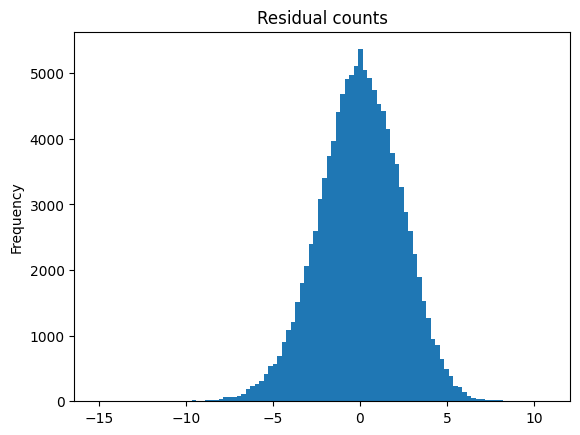

In [26]:
# Code does linear regression on each input feature against the output feature using statsmodels.formula.api
# Model is a linear regression model that is used to predict the points based on the features
# Mean of absolute error is the mean of the absolute value of the residuals
# Mean of squared error is the mean of the squared residuals
# Plot of the residuals shows the distribution of the residuals

import statsmodels.formula.api as smf

input_feature = ['vintage', 'taster_name', 'country', 'variety', 'price']
output_feature = 'points'
model = smf.ols(f"{output_feature}~{'+'.join(input_feature)}", data=df2)
result = model.fit()

print("Mean of absolute error: ", abs(result.resid).mean())

print("Mean of squared error: ", (result.resid**2).mean())

# plot residual
result.resid.plot(kind='hist', bins=100, title='Residual counts')

In [27]:
summary = result.summary()

### Extract Taster Coefficient to Substract the biased points

In [30]:
taster_coeff = (
    result
    .params
    [result.params.index.str.contains('taster_name')]
).rename("taster_bias")

# remove the prefix and suffix of index
taster_coeff.index = taster_coeff.index.str.replace('taster_name\[T.', '').str.replace('\]', '')

display(taster_coeff)

<ipython-input-30-947a100f7e82>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  taster_coeff.index = taster_coeff.index.str.replace('taster_name\[T.', '').str.replace('\]', '')
<ipython-input-30-947a100f7e82>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  taster_coeff.index = taster_coeff.index.str.replace('taster_name\[T.', '').str.replace('\]', '')


Anna Lee C. Iijima    1.966190
Anne Krebiehl MW      3.416553
Carrie Dykes          0.397808
Christina Pickard     1.795372
Fiona Adams           0.725304
Jeff Jenssen          3.376098
Jim Gordon            2.898886
Joe Czerwinski        1.605510
Kerin O’Keefe         1.523202
Lauren Buzzeo         1.159313
Matt Kettmann         3.444540
Michael Schachner     1.709552
Mike DeSimone         3.461080
Not specified         1.608027
Paul Gregutt          3.013717
Roger Voss            1.858842
Sean P. Sullivan      2.496134
Susan Kostrzewa       0.314400
Virginie Boone        2.306487
Name: taster_bias, dtype: float64

### Points Substact Reviewer Bias

In [34]:
#This code is used to remove the bias of each taster to the points they give to the wine. 
#It first creates a dataframe that contains the taster name and their bias. 
#Then it merges the dataframe with the original dataframe that contains the taster name and the points they gave to each wine. 
#Then it assigns a new column to the dataframe that contains the points of each wine minus the taster's bias. 
#Then it displays the first 5 rows of the dataframe and saves the dataframe in a .xlsx file. 

removed_bias_df = (
    df2
    .merge(
        taster_coeff, 
        left_on = "taster_name", 
        right_index = True, 
        how='left'
    )
    
    .assign(
        taster_bias = lambda _df: _df.taster_bias.fillna(0),
        unbiased_points=lambda _df: _df.points - _df.taster_bias
        )
)

display(removed_bias_df.head(5))
removed_bias_df.to_excel("unbiased_wine_review.xlsx")

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,price_level,taster_bias,unbiased_points
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,low,1.858842,85.141158
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,low,3.013717,83.986283
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,low,0.000000,87.000000
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,medium,3.013717,83.986283
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,low,1.709552,85.290448


## Obtain the negative review through sentiment analysis

In [47]:
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [38]:

# This code uses the VADER sentiment analysis tool to provide sentiment scores for each comment in the dataset. 
# It then takes the compound score and assigns a sentiment to the comment.
# The compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive). 
# The compound score is used to provide an overall sentiment score for each comment.
# The compound score is then used to assign a sentiment (positive, negative, neutral) to the comment.
# The compound score is used as it provides a more accurate sentiment score than the individual pos/neg/neu scores. 

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

sentiment = (
    pd.DataFrame(list(df2.description.apply(sid.polarity_scores)), index=df2.index)
    .rename(columns = {"neg":"negative","neu":"neutral","pos":"positive","comp":"compound"})
    .compound.apply(lambda x:"positive" if x > 0.05 else("negative" if x <= -0.05 else "neutral"))
)
removed_bias_df = removed_bias_df.assign(sentiment=sentiment)

<ipython-input-39-20072ca3d7ed>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sentiment_df.sentiment_score, bins=100, kde=False)


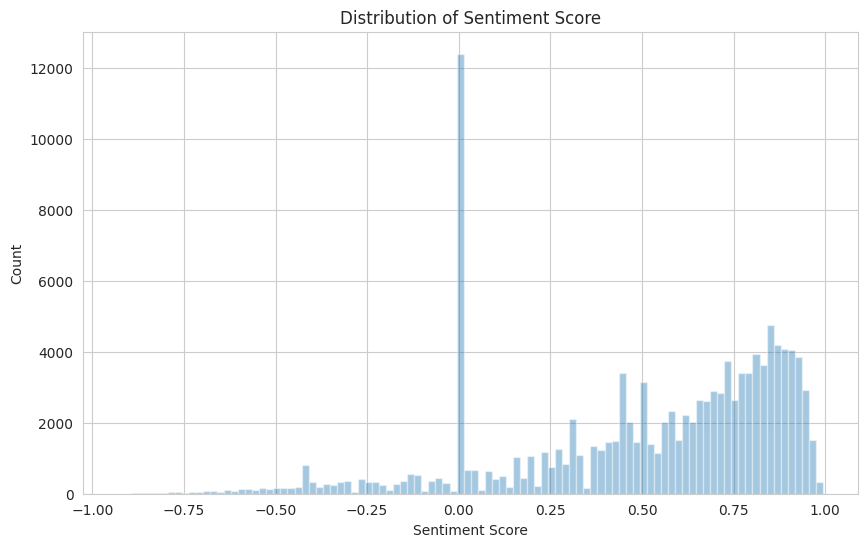

In [39]:
#sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment = removed_bias_df.description.apply(sid.polarity_scores)
sentiment = pd.DataFrame(list(sentiment), index = removed_bias_df.index)
sentiment = sentiment.rename(columns={"neg":"negative", "neu":"neutral", "pos":"positive", "compound":"compound"})
sentiment.head()

removed_bias_df['sentiment'] = sentiment.compound.apply(lambda x: "positive" if x >= 0.15 else ("negative" if x <= -0.05 else "neutral"))
sentiment_df = removed_bias_df.join(sentiment.compound.rename('sentiment_score'))

# plot the distribution of compound score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.distplot(sentiment_df.sentiment_score, bins=100, kde=False)
plt.title("Distribution of Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

## Extract taste memo in groups of countries and variety

In [48]:
# This code is used to remove stop words and punctuation marks from the description, and then lemmatize the description to its basic form. 
# Then it will extract the adjectives and noun from the description. 
# The purpose of this code is to help the machine learning model to understand the description better.

import nltk 
from nltk.stem import WordNetLemmatizer #Import WordNetlemmatizer to lemmatize the description
from string import punctuation #Import punctuation mark set
from nltk.corpus import stopwords #Import english stopword set
from nltk import pos_tag
ENG_STOPWORDS=stopwords.words("english") 
PUNCSET=list(punctuation)

lemmatizer = WordNetLemmatizer()
def nlp_pipe(description):
    description = nltk.word_tokenize(description.lower())

    description = [
        #Lemmatize the description word to its basic form
        lemmatizer.lemmatize(word) 
        for word in description 
        #Filter words either exist in stopwords or punctuation mark set
        if word not in ENG_STOPWORDS and word not in PUNCSET
        ]
    
    #Define the POS of the description words
    tagged_description = pos_tag(description)

    #Extract those words in all adjectives and noun form
    adjutive_tag_description = [word[0] for word in tagged_description if word[1] in ['JJ', 'JJR', 'JJS']]
    return list(adjutive_tag_description)

tokened_description = removed_bias_df.description.apply(nlp_pipe)

In [ ]:
tokened_df = (
    removed_bias_df
    # 85 is a good wine with special quality, ref: https://www.winespectator.com/articles/scoring-scale
    .assign(tokened_description = tokened_description)
)

tokened_df.get(['title', 'unbiased_points', 'country', 'variety', 'vintage', 'price', 'description', 'tokened_description'])


,title,unbiased_points,country,variety,vintage,price,description,tokened_description
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),87.0,Portugal,Portuguese Red,2011,15.0,"This is ripe and fruity, a wine that is smooth...","[ripe, firm, red, drinkable, better]"
2,Rainstorm 2013 Pinot Gris (Willamette Valley),87.0,US,Pinot Gris,2013,14.0,"Tart and snappy, the flavors of lime flesh and...","[snappy, flesh, green, crisp, flavor, wine]"
3,St. Julian 2013 Reserve Late Harvest Riesling ...,87.0,US,Riesling,2013,13.0,"Pineapple rind, lemon pith and orange blossom ...","[blossom, opulent, honey-drizzled, astringent]"
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,87.0,US,Pinot Noir,2012,65.0,"Much like the regular bottling from 2012, this...","[much, regular, rough, tannic, rustic, herbal,..."
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,87.0,Spain,Tempranillo-Merlot,2011,15.0,Blackberry and raspberry aromas show a typical...,"[typical, green, horseradish, full, tomatoey, ..."
...,...,...,...,...,...,...,...,...
129966,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,90.0,Germany,Riesling,2013,28.0,Notes of honeysuckle and cantaloupe sweeten th...,"[feather-light, palate, wrap, kiss]"
129967,Citation 2004 Pinot Noir (Oregon),90.0,US,Pinot Noir,2004,75.0,Citation is given as much as a decade of bottl...,"[prior, mean, pre-cellared, cherry, soft, seco..."
129968,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,90.0,France,Gewürztraminer,2013,30.0,Well-drained gravel soil gives this wine its c...,"[well-drained, dry, serious, couple]"
129969,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),90.0,France,Pinot Gris,2012,32.0,"A dry style of Pinot Gris, this is crisp with ...","[dry, solid, powerful, wine]"


In [ ]:
tokened_df.query("vintage == '2017'").sort_values(by="points",ascending=False).points

15751     89.290448
23712     85.290448
98608     84.290448
111940    84.290448
1618      83.290448
1634      83.290448
41893     83.290448
10567     82.290448
10711     82.290448
29749     82.290448
51451     82.290448
Name: points, dtype: float64

In [ ]:
def get_group_index(key):
  """
  input : the column key in df
  process :
  - aggregate the 
  """
    return (
    tokened_df
    .get([key, 'tokened_description', 'points'])
    .groupby(key)
    .agg({'tokened_description':'count', 'points':'mean'})
    .dropna()
    .query("tokened_description >= 1000")
    .sort_values('points', ascending=False)
    .index
)

def filter_key_wordlist(key):
  """
  input: the column key in df
  process : 
  - obtain the unique value in the column
  - take the keyword list of description
  - calculate the term frequencies for each key
  - get the top 30 frequent keywords
  - return the result
  output : series of term frequency under the specific key value.
  """
    for ind in get_group_index(key):
        yield (
            tokened_df
            .query(f"{key} == '{ind}'")
            .tokened_description
            .explode()
            .value_counts()
            .head(30)
            .rename(ind)
        )

# to obtain series of representative keywords for each variety
variety_wordlist = pd.DataFrame(list(filter_key_wordlist('variety'))).isna().mean()
# to retain the keywords of which occurance is less than or equal to 2.
unique_word = variety_wordlist[variety_wordlist>(1-(2/len(df2.variety.unique())))].index

variety_wordlist = pd.DataFrame(
    [set(var.index).intersection(set(unique_word)) for var in list(filter_key_wordlist('variety'))],
    index = get_group_index('variety')
)

In [33]:
1-(2/len(df2.variety.unique()))

0.002902757619738752

In [ ]:
variety_wordlist = pd.DataFrame(list(filter_key_wordlist('variety'))).isna().mean()
unique_word = variety_wordlist[variety_wordlist>0.9].index
variety_wordlist = pd.DataFrame(
    [set(var.index).intersection(set(unique_word)) for var in list(filter_key_wordlist('variety'))],
    index = get_group_index('variety')
)

variety_wordlist.to_excel("variety_wordlist.xlsx")

In [ ]:
country_wordlist = pd.DataFrame(list(filter_key_wordlist('country'))).isna().mean()
unique_word = variety_wordlist[variety_wordlist>0.8].index
country_wordlist = pd.DataFrame(
    [set(var.index).intersection(set(unique_word)) for var in list(filter_key_wordlist('country'))],
    index = get_group_index('country')
)
country_wordlist.to_excel("country_wordlist.xlsx")

In [ ]:
variety_wordlist = pd.DataFrame(list(filter_key_wordlist('sentiment'))).isna().mean()
unique_word = variety_wordlist[variety_wordlist>0.6].index
sentiment_wordlist = pd.DataFrame(
    [set(var.index).intersection(set(unique_word)) for var in list(filter_key_wordlist('sentiment'))],
    index = get_group_index('sentiment')
)
sentiment_wordlist.to_excel("sentiment_wordlist.xlsx")

In [ ]:
variety = pd.DataFrame(
    [set(var.index).intersection(set(unique_word)) for var in list(filter_key_wordlist('variety'))],
    index = get_group_index('variety')
)

variety.apply(list, axis=1)
country_wordlist.apply(list, axis=1)
sentiment_wordlist.apply(list, axis=1)

sentiment
positive    [sweet, bright, elegant, fine, complex, delici...
neutral     [wild, tight, medium-bodied, lead, simple, che...
negative    [tough, low, sour, heavy, hard, much, bitter, ...
dtype: object

In [ ]:
# merge the wordlist to the original_df to do the matching

matching_machine = removed_bias_df.merge(
    variety.apply(list, axis=1).rename('variety_wordlist'),
    left_on = "variety",
    right_index = True,
    how='left'
).merge(
    country_wordlist.apply(list, axis=1).rename('country_wordlist'),
    left_on = "country",
    right_index = True,
    how='left'
).merge(
    sentiment_wordlist.apply(list, axis=1).rename('sentiment_wordlist'),
    left_on = "sentiment",
    right_index = True,
    how='left'
).get(['variety_wordlist', 'country_wordlist', 'sentiment_wordlist', 'points', 'description']).dropna(subset=['country_wordlist', 'sentiment_wordlist', 'variety_wordlist'])

In [ ]:
def get_matching_score(line, description:list):
    country_ = line.country_wordlist
    sentiment_ = line.sentiment_wordlist
    variety_ = line.variety_wordlist
    result = [v in description for v in variety_ if v]
    variety_score = sum(result) / len(result)
    result = [v in description for v in country_ if v]
    country_score = sum(result) / len(result)
    result = [v in description for v in sentiment_ if v]
    sentiment_score = sum(result) / len(result)
    return 5*variety_score + 3*country_score + 2*sentiment_score

selected_keywords = ["Peppery", "Spicy", 'Bold', 'Intense', 'Warm', 'Rich', 'Full-bodied', 'Exotic', 'Aromatic']
result = matching_machine.apply(get_matching_score, description = selected_keywords, axis=1)

C:\Users\joech\AppData\Local\Temp\ipykernel_20760\4038870393.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(result[result>5], bins=20, kde=False)


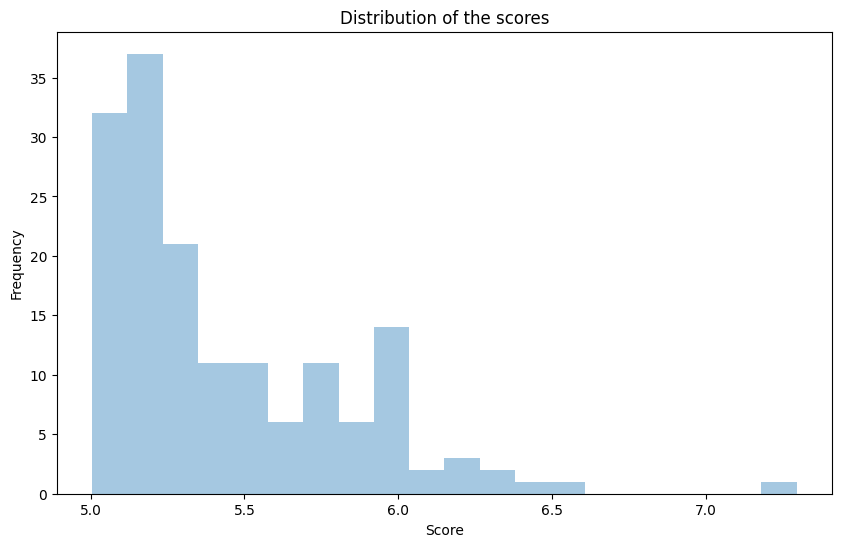

In [ ]:
# plot the distribution of the scores
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.distplot(result[result>5], bins=20, kde=False)
plt.title('Distribution of the scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# df2 pivot to show the taster name and country with count of points
df2.groupby(['taster_name', 'country']).size().unstack().fillna(0).astype(int).to_excel("taster_country.xlsx")

In [ ]:
result = [v in description for v in country_ if v]
country_score = sum(result) / len(result)

In [ ]:
result = [v in description for v in sentiment_ if v]
sentiment_score = sum(result) / len(result)

In [ ]:
5*variety_score + 3*country_score + 2*sentiment_score

1.5945165945165944